In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("retailstore").getOrCreate()
df = spark.read.option("header", "true").csv("retail_store_inventory.csv")
df.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|
|2022-01-01|    S001|     P0002|       Toys| South|            204|       150|           66|         144.04|63.01|      20|            Sunny|                0|             66.16|     Autumn|
|2022-01-01|    S001|     P0003|       Toys| 

In [10]:
df_cleaned = df.dropna()
df_filled = df.fillna({"Units Sold": 0, "Units Ordered": 0, "Price": 0.0})
df_filled.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|
|2022-01-01|    S001|     P0002|       Toys| South|            204|       150|           66|         144.04|63.01|      20|            Sunny|                0|             66.16|     Autumn|
|2022-01-01|    S001|     P0003|       Toys| 

In [8]:
from pyspark.sql.functions import col
df_cleaned = df_cleaned.withColumn("Units Sold", col("Units Sold").cast("int")) \
                       .withColumn("Price", col("Price").cast("float"))
df_cleaned.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|
|2022-01-01|    S001|     P0002|       Toys| South|            204|       150|           66|         144.04|63.01|      20|            Sunny|                0|             66.16|     Autumn|
|2022-01-01|    S001|     P0003|       Toys| 

In [11]:
df_cleaned = df_cleaned.withColumn("Total Sales", col("Units Sold") * col("Price"))
df_cleaned.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|       Total Sales|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|            4254.5|
|2022-01-01|    S001|     P0002|       Toys| South|            204|       150|           66|         144.04|63.01|      20|            Sunny|                0| 

In [12]:
sales_by_region = df_cleaned.groupBy("Region").sum("Total Sales").orderBy("sum(Total Sales)", ascending=False)
sales_by_region.show()

+------+--------------------+
|Region|    sum(Total Sales)|
+------+--------------------+
|  East|1.3871205433000028E8|
| South|1.3848356684000042E8|
| North|1.3725526734999967E8|
|  West|1.3577799639000016E8|
+------+--------------------+



In [13]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
window_spec = Window.partitionBy("Region").orderBy(col("Total Sales").desc())
df_ranked = df_cleaned.withColumn("Rank", rank().over(window_spec))

In [14]:
top_5_products = df_ranked.filter(col("Rank") <= 5).select("Region", "Product ID", "Total Sales")
top_5_products.show()

+------+----------+------------------+
|Region|Product ID|       Total Sales|
+------+----------+------------------+
|  East|     P0002|          47860.47|
|  East|     P0013|45584.119999999995|
|  East|     P0010|           45361.8|
|  East|     P0005|45212.880000000005|
|  East|     P0018|           45054.9|
| North|     P0009|          45575.88|
| North|     P0007|          45077.68|
| North|     P0001|          45023.47|
| North|     P0010|           45018.8|
| North|     P0011|44664.159999999996|
| South|     P0018|           47141.6|
| South|     P0010|45421.200000000004|
| South|     P0015|           44500.5|
| South|     P0004|          43719.94|
| South|     P0017|           43612.6|
|  West|     P0020|          46810.54|
|  West|     P0013|          46792.13|
|  West|     P0004|          45929.43|
|  West|     P0003|           45364.9|
|  West|     P0010|44195.200000000004|
+------+----------+------------------+



In [15]:
from pyspark.sql.functions import to_date, month, year
df_cleaned = df_cleaned.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
df_cleaned = df_cleaned.withColumn("Month", month(col("Date"))).withColumn("Year", year(col("Date")))
df_cleaned.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+-----+----+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|       Total Sales|Month|Year|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+-----+----+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|            4254.5|    1|2022|
|2022-01-01|    S001|     P0002|       Toys| South|            204|       150|           66|         144.04|63.01|  

In [16]:
monthly_sales = df_cleaned.groupBy("Year", "Month").agg({"Total Sales": "sum"})
monthly_sales.show(5)

+----+-----+--------------------+
|Year|Month|    sum(Total Sales)|
+----+-----+--------------------+
|2022|   10| 2.345940017359829E7|
|2022|    2|2.1184921846039772E7|
|2022|    7| 2.359868879216957E7|
|2022|   11|2.3117943414373398E7|
|2022|    3|2.4004750137041092E7|
+----+-----+--------------------+
only showing top 5 rows



In [19]:
!pip install pandas

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.6 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 5.0/12.6 MB 12.1 MB/s eta 0:00:01
   ---------------------- ----------------- 7.1/12.6 MB 11.5 MB/s eta 0:00:01
   ------------------------------- -------- 10.0/12.6 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------  12.3/12.6 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 11.1 MB/s eta 0:00:00
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
!pip install matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.8 MB 3.7 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/7.8 MB 6.7 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/7.8 MB 8.6 MB/s eta 0:00:01
   -------------------------------------- - 7.6/7.8 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 9.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------------------------------ --- 2.4/2.6 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 9.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Matplotlib is building the font cache; this may take a moment.


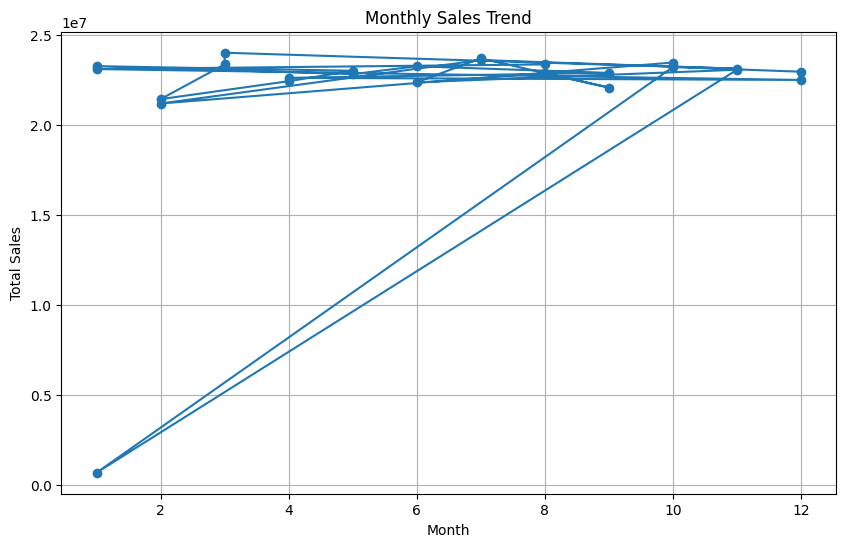

In [22]:
pandas_df = monthly_sales.toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['Month'], pandas_df['sum(Total Sales)'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [18]:
df_cleaned = df_cleaned.withColumn("Discounted Price", col("Price") * (1 - col("Discount") / 100))
df_cleaned = df_cleaned.withColumn("Profit", (col("Discounted Price") - col("Price")) * col("Units Sold"))
df_cleaned.show(5)

+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+-----+----+----------------+-------------------+
|      Date|Store ID|Product ID|   Category|Region|Inventory Level|Units Sold|Units Ordered|Demand Forecast|Price|Discount|Weather Condition|Holiday/Promotion|Competitor Pricing|Seasonality|       Total Sales|Month|Year|Discounted Price|             Profit|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+------------------+-----+----+----------------+-------------------+
|2022-01-01|    S001|     P0001|  Groceries| North|            231|       127|           55|         135.47| 33.5|      20|            Rainy|                0|             29.69|     Autumn|            4254.5|    1|2022|      

In [19]:
profitability_by_region = df_cleaned.groupBy("Region").sum("Profit").orderBy("sum(Profit)", ascending=False)
profitability_by_region.show()

+------+--------------------+
|Region|         sum(Profit)|
+------+--------------------+
|  West|-1.370991485849997E7|
| North|-1.37116049985000...|
| South|-1.391617846600005E7|
|  East|-1.39198116384999...|
+------+--------------------+

